In [1]:
import pandas as pd
import numpy as np
import csv
import pickle
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import class_weight
import math

from sklearn.ensemble import RandomForestClassifier

from scipy import interp

import os

import subprocess


In [2]:
#change to your replication folder here
path='D:\\Dropbox\\Prediction Refugees\\Programs\\replication\\'
spitout='D:\\Dropbox\\Prediction Refugees\\Programs\\replication\\'
statapath="C:\\Program Files (x86)\\Stata15\\StataSE-64"


In [3]:


city="all"
traincities=["deir-ez-zor","raqqa","hama","daraa","homs","aleppo"]

for traincity in traincities:
    filename ="prediction_"+city+"_"+traincity+".p"
    # uploading the data
    corpus_data = pd.read_pickle(os.path.join(path, filename))
    corpus_data.to_csv(spitout + "only_prediction.csv", sep='\t', encoding='utf-8')
    filename ="target_"+traincity+".p"
    # uploading the data
    train_data = pd.read_pickle(os.path.join(path, filename))
    train_data.to_csv(spitout + traincity + "_noimages.csv", sep='\t', encoding='utf-8')

    #call stata to merge
    dofile = path+"merge dense prediction other.do"
    cmd = [statapath, "-e", "do", dofile, traincity, path, spitout]
    subprocess.call(cmd)

    #this file is made in the stata do file
    filename ="prediction_"+traincity+".csv"

    # uploading the data
    corpus_data = pd.read_csv(os.path.join(path, filename))
    corpus_data.info()

    corpus_data=corpus_data.dropna(subset=['longitude', 'latitude'])
    
    #we take the cutoff value for binary predictions from the code below
    #this cutoff is chosen in the pooled sample to reach 50% tpr
    corpus_data['pred_50recall']=(corpus_data.prediction>0.8515)*1

    corpus_data['pred_50recall_l1'] = corpus_data.groupby(['patch_id'])['pred_50recall'].shift(1)
    corpus_data['pred_50recall_l2'] = corpus_data.groupby(['patch_id'])['pred_50recall'].shift(2)

    corpus_data['pred_50recall_f1'] = corpus_data.groupby(['patch_id'])['pred_50recall'].shift(-1)
    corpus_data['pred_50recall_f2'] = corpus_data.groupby(['patch_id'])['pred_50recall'].shift(-2)


    corpus_data['prediction_l1'] = corpus_data.groupby(['patch_id'])['prediction'].shift(1)
    corpus_data['prediction_l2'] = corpus_data.groupby(['patch_id'])['prediction'].shift(2)

    corpus_data['prediction_f1'] = corpus_data.groupby(['patch_id'])['prediction'].shift(-1)
    corpus_data['prediction_f2'] = corpus_data.groupby(['patch_id'])['prediction'].shift(-2)

    updated_data = pd.DataFrame({"patch_id": pd.Series([]), "futurepred": pd.Series([]), "futurecount": pd.Series([]),
                        "futurestd": pd.Series([]), "date": pd.Series([])})

    #for date in corpus_data.index.get_level_values('date').unique():
    for date in corpus_data.date.unique():
        print(date)
        future = corpus_data.drop(corpus_data[(corpus_data.date <= date)].index)
        futurepred=future.groupby('patch_id').agg(['mean', 'count', 'std']).prediction.reset_index()
        futurepred['date']=date
        futurepred.columns=['patch_id', 'futurepred', 'futurecount', 'futurestd', 'date']
        updated_data=updated_data.append(futurepred)
        del futurepred



    corpus_data=corpus_data.merge(updated_data, on=['patch_id', 'date'], how='outer')
    corpus_data.info()
    del updated_data

    updated_data = pd.DataFrame({"date": pd.Series([]), "sum": pd.Series([]), "count": pd.Series([]), "std": pd.Series([]),
                             "sum2": pd.Series([]), "count2": pd.Series([]), "std2": pd.Series([]), "sum_bin": pd.Series([]),
                             "sum_bin2": pd.Series([]), "latitude": pd.Series([]), "longitude": pd.Series([])})

    #loop through lat and long
    for lat in corpus_data.latitude.unique():
        for long in corpus_data.longitude.unique():
            #makes the sum, count and std of patches within a radius (given by sqrt(0.00000085)) which makes two spatial lags
            rowsum=corpus_data[((corpus_data['latitude']- lat)*(corpus_data['latitude']- lat)
                    +(corpus_data['longitude']-long)*(corpus_data['longitude']-long))<0.00000085].groupby('date').agg(['sum', 'count','std']).prediction.reset_index()
            #makes the sum, count and std of patches within a radius (given by sqrt(0.00000028)) which makes one spatial lag
            rowsum2=corpus_data[((corpus_data['latitude']- lat)*(corpus_data['latitude']- lat)
                    +(corpus_data['longitude']-long)*(corpus_data['longitude']-long))<0.00000028].groupby('date').agg(['sum', 'count','std']).prediction.reset_index()
    
            rowsum['sum2']=rowsum2['sum']
            rowsum['count2']=rowsum2['count']
            rowsum['std2']=rowsum2['std']
            #same with binary values - one spatial lag
            rowsum2=corpus_data[((corpus_data['latitude']- lat)*(corpus_data['latitude']- lat)
                    +(corpus_data['longitude']-long)*(corpus_data['longitude']-long))<0.00000028].groupby('date').agg(['sum']).pred_50recall.reset_index()
            rowsum['sum_bin']=rowsum2['sum']
            #same with binary values - two spatial lags
            rowsum2=corpus_data[((corpus_data['latitude']- lat)*(corpus_data['latitude']- lat)
                    +(corpus_data['longitude']-long)*(corpus_data['longitude']-long))<0.00000085].groupby('date').agg(['sum']).pred_50recall.reset_index()
            rowsum['sum_bin2']=rowsum2['sum']
        
            rowsum['latitude']=lat
            rowsum['longitude']=long
            updated_data=updated_data.append(rowsum)
            del rowsum
        print("done latitude", lat, "in", traincity)
    
    updated_data.columns= ['date', 'sum2', 'count2', 'std2', 'sum', 'count', 'std', 'sum_bin', 'sum_bin2', 'latitude', 'longitude']
    updated_data.to_csv(spitout + "prediction_features_"+city+"_"+traincity+".csv", sep='\t', encoding='utf-8')

    #after running the above code merge
    updated ="prediction_features_"+city+"_"+traincity+".csv"

    # uploading the data
    updated_data = pd.read_csv(os.path.join(path, updated), sep='\t', encoding='utf-8')
    updated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98602 entries, 0 to 98601
Data columns (total 8 columns):
city           98602 non-null object
patch_id       98602 non-null object
date           98602 non-null object
destroyed      84723 non-null float64
latitude       98602 non-null float64
longitude      98602 non-null float64
no_analysis    98602 non-null int64
prediction     98602 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 6.0+ MB
2013-10-24
2014-09-16
2014-10-15
2014-11-25
2016-04-17
2016-05-25
2016-07-06
<class 'pandas.core.frame.DataFrame'>
Int64Index: 98602 entries, 0 to 98601
Data columns (total 20 columns):
city                98602 non-null object
patch_id            98602 non-null object
date                98602 non-null object
destroyed           84723 non-null float64
latitude            98602 non-null float64
longitude           98602 non-null float64
no_analysis         98602 non-null int64
prediction          98602 non-null float64
pred_5

done latitude 35.304047 in deir-ez-zor
done latitude 35.303703000000006 in deir-ez-zor
done latitude 35.30336 in deir-ez-zor
done latitude 35.303017 in deir-ez-zor
done latitude 35.302673 in deir-ez-zor
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110320 entries, 0 to 110319
Data columns (total 12 columns):
Unnamed: 0    110320 non-null int64
date          110320 non-null object
sum2          110320 non-null float64
count2        110320 non-null float64
std2          108927 non-null float64
sum           105616 non-null float64
count         105616 non-null float64
std           103460 non-null float64
sum_bin       105616 non-null float64
sum_bin2      110320 non-null float64
latitude      110320 non-null float64
longitude     110320 non-null float64
dtypes: float64(10), int64(1), object(1)
memory usage: 10.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180184 entries, 0 to 180183
Data columns (total 8 columns):
city           180184 non-null object
patch_id       180184

done latitude 35.118996 in hama
done latitude 35.118652000000004 in hama
done latitude 35.118309 in hama
done latitude 35.117965999999996 in hama
done latitude 35.117622 in hama
done latitude 35.117278999999996 in hama
done latitude 35.116935999999995 in hama
done latitude 35.116592 in hama
done latitude 35.116248999999996 in hama
done latitude 35.167061 in hama
done latitude 35.115906 in hama
done latitude 35.115562 in hama
done latitude 35.115219 in hama
done latitude 35.114876 in hama
done latitude 35.114532000000004 in hama
done latitude 35.114189 in hama
done latitude 35.113846 in hama
done latitude 35.113503 in hama
done latitude 35.113159 in hama
done latitude 35.112815999999995 in hama
done latitude 35.166717999999996 in hama
done latitude 35.112473 in hama
done latitude 35.112128999999996 in hama
done latitude 35.111785999999995 in hama
done latitude 35.111443 in hama
done latitude 35.111098999999996 in hama
done latitude 35.110756 in hama
done latitude 35.110413 in hama
done 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202462 entries, 0 to 202461
Data columns (total 8 columns):
city           202462 non-null object
patch_id       202462 non-null object
date           202462 non-null object
destroyed      125231 non-null float64
latitude       202462 non-null float64
longitude      202462 non-null float64
no_analysis    202462 non-null int64
prediction     202462 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 12.4+ MB
2011-10-17
2012-09-06
2013-11-10
2014-04-04
2014-05-01
2014-06-03
2016-02-25
2016-04-19
2016-07-18
2016-12-05
2017-02-07
2017-06-02
2017-10-03
<class 'pandas.core.frame.DataFrame'>
Int64Index: 202462 entries, 0 to 202461
Data columns (total 20 columns):
city                202462 non-null object
patch_id            202462 non-null object
date                202462 non-null object
destroyed           125231 non-null float64
latitude            202462 non-null float64
longitude           202462 non-null float64
no_an

2016-05-30
2016-07-05
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200035 entries, 0 to 200034
Data columns (total 20 columns):
city                200035 non-null object
patch_id            200035 non-null object
date                200035 non-null object
destroyed           83941 non-null float64
latitude            200035 non-null float64
longitude           200035 non-null float64
no_analysis         200035 non-null int64
prediction          200035 non-null float64
pred_50recall       200035 non-null int32
pred_50recall_l1    160028 non-null float64
pred_50recall_l2    120021 non-null float64
pred_50recall_f1    160028 non-null float64
pred_50recall_f2    120021 non-null float64
prediction_l1       160028 non-null float64
prediction_l2       120021 non-null float64
prediction_f1       160028 non-null float64
prediction_f2       120021 non-null float64
futurepred          160028 non-null float64
futurecount         160028 non-null float64
futurestd           120021 non-null flo

done latitude 34.768806 in homs
done latitude 34.768463 in homs
done latitude 34.76812 in homs
done latitude 34.767776 in homs
done latitude 34.767433000000004 in homs
done latitude 34.770866 in homs
done latitude 34.770523 in homs
done latitude 34.770179999999996 in homs
done latitude 34.769836 in homs
done latitude 34.769493 in homs
done latitude 34.76915 in homs
done latitude 34.772926 in homs
done latitude 34.772583000000004 in homs
done latitude 34.772240000000004 in homs
done latitude 34.771896000000005 in homs
done latitude 34.771553000000004 in homs
done latitude 34.771209999999996 in homs
done latitude 34.773613 in homs
done latitude 34.773270000000004 in homs
done latitude 34.7743 in homs
done latitude 34.773956 in homs
done latitude 34.694649 in homs
done latitude 34.694305 in homs
done latitude 34.693962 in homs
done latitude 34.693619 in homs
done latitude 34.693275 in homs
done latitude 34.692932 in homs
done latitude 34.692589 in homs
done latitude 34.692245 in homs
done

done latitude 36.167503 in aleppo
done latitude 36.167159999999996 in aleppo
done latitude 36.166817 in aleppo
done latitude 36.166472999999996 in aleppo
done latitude 36.166129999999995 in aleppo
done latitude 36.165787 in aleppo
done latitude 36.165442999999996 in aleppo
done latitude 36.1651 in aleppo
done latitude 36.164757 in aleppo
done latitude 36.164413 in aleppo
done latitude 36.16407 in aleppo
done latitude 36.163727 in aleppo
done latitude 36.163383 in aleppo
done latitude 36.16304 in aleppo
done latitude 36.162696999999994 in aleppo
done latitude 36.162354 in aleppo
done latitude 36.162009999999995 in aleppo
done latitude 36.161667 in aleppo
done latitude 36.161324 in aleppo
done latitude 36.16098 in aleppo
done latitude 36.160637 in aleppo
done latitude 36.160294 in aleppo
done latitude 36.15995 in aleppo
done latitude 36.159607 in aleppo
done latitude 36.159264 in aleppo
done latitude 36.15892 in aleppo
done latitude 36.158577 in aleppo
done latitude 36.158234 in aleppo
d

In [3]:
#second stage estimation and application and calculation of table 1 starts here

#define programs

#readcity takes files as they are generated by the dense prediction maker after the CNN (first stage)
#it then merges this dense prediction data with the features generated in the feature generationg code using STATA
#note that dense prediction still implies a training/test partition which we mantain throughout
#the only exception is the very last step in which we train using all the labelled data to print out predicted values

def readcity(cityname, targetcity):
    filename ="prediction_"+cityname+"_"+targetcity+".p"
    # uploading the data
    corpus_data = pd.read_pickle(os.path.join(path, filename))
    corpus_data.to_csv(spitout + "only_prediction.csv", sep='\t', encoding='utf-8')
    filename ="target_"+targetcity+".p"
    # uploading the data
    target_data = pd.read_pickle(os.path.join(path, filename))
    target_data.to_csv(spitout + targetcity + "_noimages.csv", sep='\t', encoding='utf-8')

    #call STATA to merge datasets
    dofile = path+"merge dense prediction other.do"
    cmd = [statapath, "-e", "do", dofile, targetcity, path, spitout]
    subprocess.call(cmd)

    #this file is made in the stata do file and contains the merge
    filename_city ="prediction_"+targetcity+".csv"

    # uploading the data
    corpus_data = pd.read_csv(os.path.join(path, filename_city))
    corpus_data.info()
    
    #the following features are not used but used to be generated
    corpus_data['pred_50recall']=(corpus_data.prediction>0.8515)*1

    corpus_data['pred_50recall_l1'] = corpus_data.groupby(['patch_id'])['pred_50recall'].shift(1)
    corpus_data['pred_50recall_l2'] = corpus_data.groupby(['patch_id'])['pred_50recall'].shift(2)

    corpus_data['pred_50recall_f1'] = corpus_data.groupby(['patch_id'])['pred_50recall'].shift(-1)
    corpus_data['pred_50recall_f2'] = corpus_data.groupby(['patch_id'])['pred_50recall'].shift(-2)

    #doing padding
    vlist=['pred_50recall_l1', 'pred_50recall_l2', 'pred_50recall_f1', 'pred_50recall_f2']
    for var in vlist:
        corpus_data[var]=corpus_data[var].combine_first(corpus_data["pred_50recall"])

    corpus_data['prediction_l1'] = corpus_data.groupby(['patch_id'])['prediction'].shift(1)
    corpus_data['prediction_l2'] = corpus_data.groupby(['patch_id'])['prediction'].shift(2)

    corpus_data['prediction_f1'] = corpus_data.groupby(['patch_id'])['prediction'].shift(-1)
    corpus_data['prediction_f2'] = corpus_data.groupby(['patch_id'])['prediction'].shift(-2)

    #doing padding
    vlist=['prediction_l1', 'prediction_l2', 'prediction_f1', 'prediction_f2']
    for var in vlist:
        corpus_data[var]=corpus_data[var].combine_first(corpus_data["prediction"])

    corpus_data["latitude"]=corpus_data.latitude.round(6)
    corpus_data["longitude"]=corpus_data.longitude.round(6)
    #the file below comes from a different file that needs to be run first
    updated ="prediction_features_"+cityname+"_"+targetcity+".csv"


    # uploading the data
    updated_data = pd.read_csv(os.path.join(path, updated), sep='\t', encoding='utf-8')
    del updated_data['Unnamed: 0']
    updated_data["latitude"]=updated_data.latitude.round(6)
    updated_data["longitude"]=updated_data.longitude.round(6)

    corpus_data_add=corpus_data.merge(updated_data, on=['latitude', 'longitude', 'date'], how='inner')


    del corpus_data
    del updated_data
    return corpus_data_add




In [4]:
#this codes uses data that is passed to estimate four models
#full model (spatial information and two lags of temporal information)
#model using just spatial information
#model just using temporal information
#full model but with only using one temporal lag

def estimatemodel(corpus_data2, cityname):
    #add features
    corpus_data2["count1"]=corpus_data2["count"]-1
    corpus_data2["count2"]=corpus_data2["count2"]-1

    corpus_data2["pred_c1"]=(corpus_data2["sum"]-corpus_data2["prediction"])/corpus_data2["count"]
    corpus_data2["pred_c2"]=(corpus_data2["sum2"]-corpus_data2["prediction"])/corpus_data2["count2"]

    corpus_data2["pred_50recall_c1"]=(corpus_data2["sum_bin"]-corpus_data2["pred_50recall"])/corpus_data2["count"]
    corpus_data2["pred_50recall_c2"]=(corpus_data2["sum_bin2"]-corpus_data2["pred_50recall"])/corpus_data2["count2"]


    #simplest possible model
    model = []
    model.append("prediction")
    model.append("destroyed")
    model.append("prediction_l1")
    model.append("prediction_l2")
    model.append("prediction_f1")
    model.append("prediction_f2")
    model.append("std")
    model.append("std2")
    model.append("count")
    model.append("count2")
    model.append("sum_bin")
    model.append("sum_bin2")

    model.append("pred_c1")
    model.append("pred_c2")


    data = corpus_data2[model]
    data = data.dropna(how='any').reset_index()

    data.info()

    y_within=data.destroyed

    preds_within=data.prediction

    preds_avrg=(data["prediction"]+data["prediction_f1"]+data["prediction_f2"])/3


    
    model_RF=['prediction', 'prediction_l2', 'prediction_l1', 'prediction_f1', 'prediction_f2', "pred_c1", "pred_c2", "sum_bin", "sum_bin2", "std", "std2", "count", "count2"]
    model_RF1=['prediction', 'prediction_l2', 'prediction_l1', 'prediction_f1', 'prediction_f2']
    model_RF2=['prediction', "pred_c1", "pred_c2", "sum_bin", "sum_bin2", "std", "std2", "count", "count2"]
    model_RF3=['prediction', 'prediction_l1', 'prediction_f1', "pred_c1", "pred_c2", "sum_bin", "sum_bin2", "std", "std2", "count", "count2"]


    X_RF=data[model_RF]
    X_RF_dense=corpus_data2[model_RF]
    
    X_RF1=data[model_RF1]
    X_RF1_dense=corpus_data2[model_RF1]

    X_RF2=data[model_RF2]
    X_RF2_dense=corpus_data2[model_RF2]

    X_RF3=data[model_RF3]
    X_RF3_dense=corpus_data2[model_RF3]
    
    clf_RF = RandomForestClassifier(300, max_depth=15, min_samples_split =2, min_samples_leaf = 20,  n_jobs=-1, random_state =1)
    clf_RF2 = RandomForestClassifier(300, max_depth=15, min_samples_split =2, min_samples_leaf = 20,  n_jobs=-1, random_state =1 )
    clf_RF1 = RandomForestClassifier(300, max_depth=15, min_samples_split =2, min_samples_leaf = 20,  n_jobs=-1, random_state =1 )
    clf_RF3 = RandomForestClassifier(300, max_depth=15, min_samples_split =2, min_samples_leaf = 20,  n_jobs=-1, random_state =1 )
        
        
    print("estimating forest with lags")
    clf_RF.fit(X_RF,y_within)
        
    print("estimating forest with only spatial lags")
    clf_RF2.fit(X_RF2,y_within)
    
    print("estimating forest with only temporal lags")
    clf_RF1.fit(X_RF1,y_within)
    
    print("estimating forest with one temporal lag")
    clf_RF3.fit(X_RF3,y_within)
    
    p_RF_within = clf_RF.predict_proba(X_RF)[:, 1]
    p_RF2_within = clf_RF2.predict_proba(X_RF2)[:, 1]
    p_RF1_within = clf_RF1.predict_proba(X_RF1)[:, 1]
    p_RF3_within = clf_RF3.predict_proba(X_RF3)[:, 1]
    p_ENS_within = np.mean([p_RF1_within, p_RF2_within], axis=0)
    
    corpus_data2["random_forest_pred"] = clf_RF.predict_proba(X_RF_dense)[:, 1]
    corpus_data2["random_forest_pred_sp"] = clf_RF2.predict_proba(X_RF2_dense)[:, 1]
    corpus_data2["random_forest_temp"] = clf_RF1.predict(X_RF1_dense)
    corpus_data2["random_forest_full1l"] = clf_RF3.predict(X_RF3_dense)
    
    #corpus_data2.to_csv(spitout + "prediction_MLcleaned_"+cityname+".csv", sep='\t', encoding='utf-8')


    
    return clf_RF, clf_RF2, clf_RF1, clf_RF3, y_within, preds_within, p_RF_within, p_RF2_within, p_RF1_within, p_RF3_within



In [5]:
#apply to calculate AUC

def applymodel(clf_RF_app, clf_RF2_app, clf_RF1_app, clf_RF3_app, cityname, corpus_data2, printing):
    print("Looking at ", cityname)
    #add features
    corpus_data2["count1"]=corpus_data2["count"]-1
    corpus_data2["count2"]=corpus_data2["count2"]-1

    corpus_data2["pred_c1"]=(corpus_data2["sum"]-corpus_data2["prediction"])/corpus_data2["count"]
    corpus_data2["pred_c2"]=(corpus_data2["sum2"]-corpus_data2["prediction"])/corpus_data2["count2"]

    corpus_data2["pred_50recall_c1"]=(corpus_data2["sum_bin"]-corpus_data2["pred_50recall"])/corpus_data2["count"]
    corpus_data2["pred_50recall_c2"]=(corpus_data2["sum_bin2"]-corpus_data2["pred_50recall"])/corpus_data2["count2"]


    #simplest possible model
    model = []
    model.append("prediction")
    model.append("destroyed")
    model.append("prediction_l1")
    model.append("prediction_l2")
    model.append("prediction_f1")
    model.append("prediction_f2")
    model.append("std")
    model.append("std2")
    model.append("count")
    model.append("count2")
    model.append("sum_bin")
    model.append("sum_bin2")

    model.append("pred_c1")
    model.append("pred_c2")


    data_app = corpus_data2[model]
    data_app = data_app.dropna(how='any').reset_index()

    data_app.info()
    
    y=data_app.destroyed

    preds=data_app.prediction


    model_RF=['prediction', 'prediction_l2', 'prediction_l1', 'prediction_f1', 'prediction_f2', "pred_c1", "pred_c2", "sum_bin", "sum_bin2", "std", "std2", "count", "count2"]
    model_RF1=['prediction', 'prediction_l2', 'prediction_l1', 'prediction_f1', 'prediction_f2']
    model_RF2=['prediction', "pred_c1", "pred_c2", "sum_bin", "sum_bin2", "std", "std2", "count", "count2"]
    model_RF3=['prediction', 'prediction_l1', 'prediction_f1', "pred_c1", "pred_c2", "sum_bin", "sum_bin2", "std", "std2", "count", "count2"]


    X_RF=data_app[model_RF]
    X_RF_dense=corpus_data2[model_RF]
    
    X_RF1=data_app[model_RF1]
    X_RF1_dense=corpus_data2[model_RF1]

    X_RF2=data_app[model_RF2]
    X_RF2_dense=corpus_data2[model_RF2]

    X_RF3=data_app[model_RF3]
    X_RF3_dense=corpus_data2[model_RF3]


    weight = y.shape[0]/(2*np.bincount(y))
    weightloss=weight[1]/weight[0]
    print("this means the zeros have a weight that is", weightloss, "times higher")

    unb_weights=class_weight.compute_sample_weight({0:1,1:1}, y)

    b_weights=class_weight.compute_sample_weight({0:weight[0],1:weight[1]}, y)
        
    print("apply forest")
    p_RF = clf_RF_app.predict_proba(X_RF)[:, 1]
    print("apply temporal")
    p_RF1 = clf_RF1_app.predict_proba(X_RF1)[:, 1]
    print("apply spatial")
    p_RF2 = clf_RF2_app.predict_proba(X_RF2)[:, 1]
    print("apply one lag model")
    p_RF3 = clf_RF3_app.predict_proba(X_RF3)[:, 1]


        
    p_ENS = np.mean([p_RF1, p_RF2], axis=0)
    
    if printing==1:

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        precs = []

        avprecs=[]

        i=1
        print("Producing graphs for "+cityname)

        fpr, tpr, thresholds = roc_curve(y, preds, sample_weight=b_weights)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=4, color='cornflowerblue',
            label='ROC curve first stage (AUC = %0.2f)' % (roc_auc))

        fpr, tpr, thresholds = roc_curve(y, p_RF, sample_weight=b_weights)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

        roc_auc2 = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=4, color='maroon', linestyle='--',
            label='ROC curve second stage (AUC = %0.2f)' % (roc_auc2))


        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)


        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        #plt.title('Daraa: Out of Sample')
        plt.legend(loc="lower right")
        plt.savefig(spitout+'auc_'+cityname+'.pdf')
        plt.savefig(spitout+'auc_'+cityname+'.eps')
        plt.show()



        #precision recall
        precision, recall, thresholds = precision_recall_curve(y, preds, sample_weight=unb_weights)
        avprec=average_precision_score(y, preds, sample_weight=unb_weights)

        plt.plot(recall, precision, lw=4, color='cornflowerblue',
            label='unb. sample, CNN only (av. Pr. = %0.2f)' % (avprec))

        precision, recall, thresholds = precision_recall_curve(y, p_RF2, sample_weight=unb_weights)
        avprec=average_precision_score(y, p_RF2, sample_weight=unb_weights)

        plt.plot(recall, precision, lw=3, color='darkviolet', linestyle=':',
            label='unb. sample, CNN + spatial (av. Pr. = %0.2f)' % (avprec))


        precision, recall, thresholds = precision_recall_curve(y, p_RF, sample_weight=unb_weights)
        avprec=average_precision_score(y, p_RF, sample_weight=unb_weights)

        plt.plot(recall, precision, lw=4, color='maroon', linestyle='--',
            label='unb. sample, CNN + spatial + temporal (av. Pr. = %0.2f)' % (avprec))






        plt.xlim([0.001, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')

        #plt.title('Precision Recall Curves')
        plt.legend(loc="upper right")
        plt.savefig(spitout+'precision_'+cityname+'.pdf')
        plt.savefig(spitout+'precision_'+cityname+'.eps')
        plt.show()

        print("precision in the balanced sample with rf is", average_precision_score(y, p_RF, sample_weight=b_weights))
        print("precision in the unbalanced sample with rf is", average_precision_score(y, p_RF, sample_weight=unb_weights))

        print("precision in the balanced sample with ens is", average_precision_score(y, p_ENS, sample_weight=b_weights))
        print("precision in the unbalanced sample with ens is", average_precision_score(y, p_ENS, sample_weight=unb_weights))

        print("AUC with RF is", roc_auc_score(y,p_RF))
        print("AUC with ENS is", roc_auc_score(y,p_ENS))
    
    return (data_app['prediction'].count(),
            data_app['destroyed'].count(),
            data_app[data_app.destroyed == 1].shape[0],
            roc_auc_score(y, preds), 
            average_precision_score(y, preds, sample_weight=b_weights), 
            average_precision_score(y, preds, sample_weight=unb_weights),
            roc_auc_score(y, p_RF2), 
            average_precision_score(y, p_RF2, sample_weight=b_weights), 
            average_precision_score(y, p_RF2, sample_weight=unb_weights),
            roc_auc_score(y, p_RF), 
            average_precision_score(y, p_RF, sample_weight=b_weights), 
            average_precision_score(y, p_RF, sample_weight=unb_weights),
            roc_auc_score(y, p_RF1), 
            average_precision_score(y, p_RF1, sample_weight=b_weights), 
            average_precision_score(y, p_RF1, sample_weight=unb_weights),
            roc_auc_score(y, p_RF3), 
            average_precision_score(y, p_RF3, sample_weight=b_weights), 
            average_precision_score(y, p_RF3, sample_weight=unb_weights))
    




In [6]:
#save dense out of sample

def applymodelsaveout(clf_RF_app, clf_RF2_app, clf_RF1_app,clf_RF3_app,cityname, corpus_data2):
    print("Looking at ", cityname)
    #add features
    
    corpus_data2["count1"]=corpus_data2["count"]-1
    corpus_data2["count2"]=corpus_data2["count2"]-1

    corpus_data2["pred_c1"]=(corpus_data2["sum"]-corpus_data2["prediction"])/corpus_data2["count"]
    corpus_data2["pred_c2"]=(corpus_data2["sum2"]-corpus_data2["prediction"])/corpus_data2["count2"]

    corpus_data2["pred_50recall_c1"]=(corpus_data2["sum_bin"]-corpus_data2["pred_50recall"])/corpus_data2["count"]
    corpus_data2["pred_50recall_c2"]=(corpus_data2["sum_bin2"]-corpus_data2["pred_50recall"])/corpus_data2["count2"]


    #simplest possible model
    model = []
    model.append("prediction")
    model.append("destroyed")
    model.append("prediction_l1")
    model.append("prediction_l2")
    model.append("prediction_f1")
    model.append("prediction_f2")
    model.append("std")
    model.append("std2")
    model.append("count")
    model.append("count2")
    model.append("sum_bin")
    model.append("sum_bin2")

    model.append("pred_c1")
    model.append("pred_c2")


    data_app = corpus_data2[model]
    data_app = data_app.dropna(how='any').reset_index()

    data_app.info()

    y=data_app.destroyed

    preds=data_app.prediction


    
    model_RF=['prediction', 'prediction_l2', 'prediction_l1', 'prediction_f1', 'prediction_f2', "pred_c1", "pred_c2", "sum_bin", "sum_bin2", "std", "std2", "count", "count2"]
    model_RF1=['prediction', 'prediction_l2', 'prediction_l1', 'prediction_f1', 'prediction_f2']
    model_RF2=['prediction', "pred_c1", "pred_c2", "sum_bin", "sum_bin2", "std", "std2", "count", "count2"]
    model_RF3=['prediction', 'prediction_l1', 'prediction_f1', "pred_c1", "pred_c2", "sum_bin", "sum_bin2", "std", "std2", "count", "count2"]


    X_RF=data_app[model_RF]
    X_RF_dense=corpus_data2[model_RF]
    
    X_RF1=data_app[model_RF1]
    X_RF1_dense=corpus_data2[model_RF1]

    X_RF2=data_app[model_RF2]
    X_RF2_dense=corpus_data2[model_RF2]

    X_RF3=data_app[model_RF3]
    X_RF3_dense=corpus_data2[model_RF3]




    weight = y.shape[0]/(2*np.bincount(y))
    weightloss=weight[1]/weight[0]
    print("this means the zeros have a weight that is", weightloss, "times higher")

    unb_weights=class_weight.compute_sample_weight({0:1,1:1}, y)

    b_weights=class_weight.compute_sample_weight({0:weight[0],1:weight[1]}, y)
        
    print("apply forest")
    p_RF = clf_RF_app.predict_proba(X_RF)[:, 1]
    
    print("apply spatial forest")
    p_RF2 = clf_RF2_app.predict_proba(X_RF2)[:, 1]

    print("apply temporal forest")
    p_RF1 = clf_RF1_app.predict(X_RF1)
    
    print("apply temporal one lag")
    p_RF3 = clf_RF3_app.predict(X_RF3)
        
    p_ENS = np.mean([p_RF1, p_RF2], axis=0)

    corpus_data2["random_forest_pred"] = clf_RF_app.predict_proba(X_RF_dense)[:, 1]
    corpus_data2["random_forest_pred_sp"] = clf_RF2_app.predict_proba(X_RF2_dense)[:, 1]
    corpus_data2["random_forest_pred_temp"] = clf_RF1_app.predict_proba(X_RF1_dense)[:, 1]
    corpus_data2["random_forest_pred_full1l"] = clf_RF3_app.predict_proba(X_RF3_dense)[:, 1]
    # uploading the data for test in STATA
    corpus_data2.info()
    corpus_data2.to_csv(spitout + "prediction_MLcleaned_all_"+cityname+".csv", sep='\t', encoding='utf-8')





In [7]:
def composetraining(cityname):
    print("composing training data for " + cityname)
    traindata=pd.DataFrame()
    for cityaddname in citylist:
        if cityaddname!=cityname:
            print("appending " + cityaddname)
            traindata= traindata.append(citydata[cityaddname])

    return traindata


In [8]:
def resultswriter(city_result, date_result, totdates, mylist):
    result = pd.DataFrame({"city": pd.Series(city_result), 
                           "date": pd.Series(date_result),
                           "numberofdates": pd.Series(totdates),
                           "obs": pd.Series([mylist[0]]),
                           "labels": pd.Series([mylist[1]]),
                           "labels1": pd.Series([mylist[2]]),
                           "AUC_1": pd.Series([mylist[3]]), 
                           "avprecision1to1_1": pd.Series([mylist[4]]), 
                           "avprecision_1": pd.Series([mylist[5]]),
                           "AUC_sp": pd.Series([mylist[6]]), 
                           "avprecision1to1_sp": pd.Series([mylist[7]]), 
                           "avprecision_sp": pd.Series([mylist[8]]),
                           "AUC_full": pd.Series([mylist[9]]), 
                           "avprecision1to1_full": pd.Series([mylist[10]]), 
                           "avprecision_full": pd.Series([mylist[11]]),
                           "AUC_temp": pd.Series([mylist[12]]), 
                           "avprecision1to1_temp": pd.Series([mylist[13]]), 
                           "avprecision_temp": pd.Series([mylist[14]]),
                           "AUC_full1l": pd.Series([mylist[15]]), 
                           "avprecision1to1_full1l": pd.Series([mylist[16]]), 
                           "avprecision_full1l": pd.Series([mylist[17]])
                          })
    global results
    results = pd.concat([results,result])

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 626780 entries, (aleppo, 10016-10336, 2013-05-26 00:00:00) to (raqqa, 9952-8416, 2015-02-02 00:00:00)
Data columns (total 6 columns):
annotation_date    78291 non-null datetime64[ns]
destroyed          626780 non-null float64
latitude           626780 non-null float64
longitude          626780 non-null float64
no_analysis        626780 non-null float64
prediction         626780 non-null float32
dtypes: datetime64[ns](1), float32(1), float64(4)
memory usage: 35.7+ MB
this means the zeros have a weight that is 40.23552631578948 times higher
the AUC is 0.8569649358390165
precision (scan sample) 0.03959677945107243
precision (1:1 sample) 0.6239023186110055


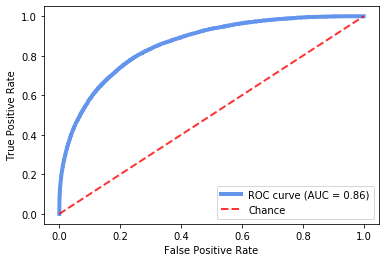

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


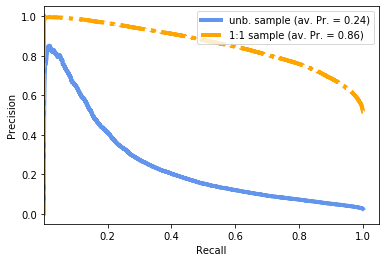

In [9]:
#make within stats

#the test below is the experiment test sample for all cities
filename ="test_set_1594832153.p"
# loading the data
testset = pd.read_pickle(os.path.join(path, filename))
testset.info()
corpus_data=testset


#call within first stage


corpus_data.destroyed=corpus_data.destroyed.astype(int)


y_train=corpus_data.destroyed
preds=corpus_data.prediction
weight = y_train.shape[0]/(2*np.bincount(y_train))
weightloss=weight[1]/weight[0]
print("this means the zeros have a weight that is", weightloss, "times higher")

unb_weights=class_weight.compute_sample_weight({0:1,1:1}, y_train)

b_weights=class_weight.compute_sample_weight({0:weight[0],1:weight[1]}, y_train)



print("the AUC is", roc_auc_score(y_train, preds, sample_weight=b_weights))
print("precision (scan sample)", precision_score(y_train, corpus_data.prediction.round()==1, sample_weight=unb_weights))
print("precision (1:1 sample)", precision_score(y_train, corpus_data.prediction.round()==1, sample_weight=b_weights))


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

precs = []

avprecs=[]

i=1

fpr, tpr, thresholds = roc_curve(y_train, preds, sample_weight=b_weights)
tprs.append(interp(mean_fpr, fpr, tpr))
tprs[-1][0] = 0.0
        
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)

plt.plot(fpr, tpr, lw=4, color='cornflowerblue',
    label='ROC curve (AUC = %0.2f)' % (roc_auc))

    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.savefig(spitout+'cv_roc.pdf')
plt.show()


precision, recall, thresholds = precision_recall_curve(y_train, preds, sample_weight=unb_weights)
avprec=average_precision_score(y_train, preds, sample_weight=unb_weights)

plt.plot(recall, precision, lw=4, color='cornflowerblue',
    label='unb. sample (av. Pr. = %0.2f)' % (avprec))

precision, recall, thresholds = precision_recall_curve(y_train, preds, sample_weight=b_weights)
avprec=average_precision_score(y_train, preds, sample_weight=b_weights)
        
plt.plot(recall, precision, lw=4, linestyle='-.', color='orange',
    label='1:1 sample (av. Pr. = %0.2f)' % (avprec))



        
plt.xlim([0.001, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.title('Precision Recall Curves')
plt.legend(loc="upper right")
plt.savefig(spitout+'precision_recall_first_stage_all.pdf')
plt.savefig(spitout+'precision_recall_first_stage_all.eps')
plt.show()




In [10]:
#check by hand for threshold that gets to TPR=0.5
threshold=0.8515
print("")
print("high threshold to get to tpr of 0.5")
print("recall on the positives is ", recall_score(y_train, (corpus_data.prediction>threshold)==1, sample_weight=b_weights))
print("precision on the positives at this threshold is (scan sample) ", precision_score(y_train, (corpus_data.prediction>threshold)==1, sample_weight=unb_weights))
print("precision on the positives at this threshold is (1:1 sample) ", precision_score(y_train, (corpus_data.prediction>threshold)==1, sample_weight=b_weights))



high threshold to get to tpr of 0.5
recall on the positives is  0.5009210526315754
precision on the positives at this threshold is (scan sample)  0.1529253449557131
precision on the positives at this threshold is (1:1 sample)  0.8789911742642448


In [11]:
#reading in all cities for later application
citylist=["deir-ez-zor","raqqa","hama","daraa","homs","aleppo"]

citydata = {}
target="all"
for cityname in citylist:
    print("reading " + cityname)
    citydata[cityname]=readcity(target, cityname)

    
    
#prepare training and test data by reading in all data
#alldata is a dataset containing labels and predicted values from the CNN for all observations
#this will be split into trainset and testset below using the indicators from the STATA merge command
#we do this by fist merging the entire with the test set of the CNN
#those observations that match (mached (3)) are then attributed to the test set in the second stage as well
#those observations that are only in the traindata (master only (1)) must therefore be training data

print("composing corpus data going through all cities")
print("**********************************************")
alldata=composetraining(target)
alldata.to_csv(spitout + target + "_noimages.csv", sep='\t', encoding='utf-8')

testset=testset.reset_index(level=['date'])
testset=testset.drop(['destroyed', 'no_analysis', 'prediction', 'annotation_date'], axis=1)
testset.info()
testset.to_csv(spitout + "testset.csv", sep='\t', encoding='utf-8')

#call stata to merge
dofile = path+"merge test set allcities.do"
cmd = [statapath, "-e", "do", dofile, target, path, spitout]
subprocess.call(cmd)

#this file is made in the stata do file
filename_city ="prediction_"+target+".csv"



# loading the merged alldata as the corpus (this contains all data)
corpus = pd.read_csv(os.path.join(path, filename_city))
corpus.info()

#make summary statistics

df_by_city = corpus.groupby(['city'])
for date_loop, wave in df_by_city:
    print("observations for " + date_loop, wave.prediction.count())
    print("labels for " + date_loop, wave.destroyed.value_counts())

    
    
    
#take over train and test split from first stage
testset = corpus['_merge'] == "matched (3)"
corpus[testset].info()
trainset = corpus['_merge'] == "master only (1)"
corpus[trainset].info()

reading deir-ez-zor
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98602 entries, 0 to 98601
Data columns (total 8 columns):
city           98602 non-null object
patch_id       98602 non-null object
date           98602 non-null object
destroyed      84723 non-null float64
latitude       98602 non-null float64
longitude      98602 non-null float64
no_analysis    98602 non-null int64
prediction     98602 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 6.0+ MB
reading raqqa
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180184 entries, 0 to 180183
Data columns (total 8 columns):
city           180184 non-null object
patch_id       180184 non-null object
date           180184 non-null object
destroyed      112481 non-null float64
latitude       180184 non-null float64
longitude      180184 non-null float64
no_analysis    180184 non-null int64
prediction     180184 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 11.0+ MB
reading hama
<cla

D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630881 entries, 0 to 1630880
Data columns (total 15 columns):
index            1630881 non-null int64
prediction       1630881 non-null float64
destroyed        1630881 non-null float64
prediction_l1    1630881 non-null float64
prediction_l2    1630881 non-null float64
prediction_f1    1630881 non-null float64
prediction_f2    1630881 non-null float64
std              1630881 non-null float64
std2             1630881 non-null float64
count            1630881 non-null int64
count2           1630881 non-null int64
sum_bin          1630881 non-null int64
sum_bin2         1630881 non-null int64
pred_c1          1630881 non-null float64
pred_c2          1630881 non-null float64
dtypes: float64(10), int64(5)
memory usage: 186.6 MB
estimating forest with lags
estimating forest with only spatial lags
estimating forest with only temporal lags
estimating forest with one temporal lag


D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guid

Looking at  all


D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626780 entries, 0 to 626779
Data columns (total 15 columns):
index            626780 non-null int64
prediction       626780 non-null float64
destroyed        626780 non-null float64
prediction_l1    626780 non-null float64
prediction_l2    626780 non-null float64
prediction_f1    626780 non-null float64
prediction_f2    626780 non-null float64
std              626780 non-null float64
std2             626780 non-null float64
count            626780 non-null int64
count2           626780 non-null int64
sum_bin          626780 non-null int64
sum_bin2         626780 non-null int64
pred_c1          626780 non-null float64
pred_c2          626780 non-null float64
dtypes: float64(10), int64(5)
memory usage: 71.7 MB
this means the zeros have a weight that is 40.23552631578948 times higher
apply forest
apply temporal
apply spatial
apply one lag model
Producing graphs for all


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


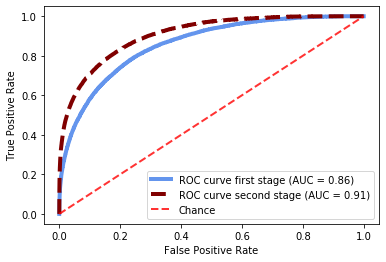

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


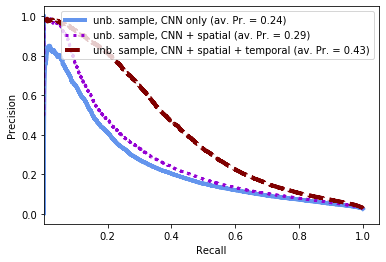

precision in the balanced sample with rf is 0.9102861080033556
precision in the unbalanced sample with rf is 0.42524153967409295
precision in the balanced sample with ens is 0.901677373804943
precision in the unbalanced sample with ens is 0.395572214001797
AUC with RF is 0.9067718856120729
AUC with ENS is 0.8978890501049053


In [12]:
#overall out of sample performance is calculated now

#collect training data (training set in corpus)
trainpartdata=corpus[trainset]

#save under functions the estimated model
functions=estimatemodel(trainpartdata, target)
#returns clf_RF, clf_RF2, clf_RF1, clf_RF3, y_within, preds_within, p_RF_within, p_RF2_within, p_RF1_within, p_RF3_within


#apply the model to all patches in the test sample
#save results in dataframe

#setting up dataframe for results stats
results = pd.DataFrame({"city": pd.Series([]), "date": pd.Series([]), "numberofdates": pd.Series([]),
                        "obs": pd.Series([]), "labels": pd.Series([]), "labels1": pd.Series([]), 
                        "AUC_1": pd.Series([]), "avprecision1to1_1": pd.Series([]), "avprecision_1": pd.Series([]),
                        "AUC_sp": pd.Series([]), "avprecision1to1_sp": pd.Series([]), "avprecision_sp": pd.Series([]),
                        "AUC_full": pd.Series([]), "avprecision1to1_full": pd.Series([]), "avprecision_full": pd.Series([]),
                        "AUC_temp": pd.Series([]), "avprecision1to1_temp": pd.Series([]), "avprecision_temp": pd.Series([]),
                        "AUC_full1l": pd.Series([]), "avprecision1to1_full1l": pd.Series([]), "avprecision_full1l": pd.Series([]),
                       })

#overall performance across all images is saved with target=all and date=alldates
performance=list(applymodel(functions[0], functions[1], functions[2], functions[3], target, corpus[testset],1))
#    returns (data_app['prediction'].count(),
#            data_app['destroyed'].count(),
#            data_app[data_app.destroyed == 1].shape[0],
#            roc_auc_score(y, preds), 
#            average_precision_score(y, preds, sample_weight=b_weights), 
#            average_precision_score(y, preds, sample_weight=unb_weights),
#            roc_auc_score(y, p_RF2), 
#            average_precision_score(y, p_RF2, sample_weight=b_weights), 
#            average_precision_score(y, p_RF2, sample_weight=unb_weights),
#            roc_auc_score(y, p_RF), 
#            average_precision_score(y, p_RF, sample_weight=b_weights), 
#            average_precision_score(y, p_RF, sample_weight=unb_weights),
#            roc_auc_score(y, p_RF1), 
#            average_precision_score(y, p_RF1, sample_weight=b_weights), 
#            average_precision_score(y, p_RF1, sample_weight=unb_weights),
#            roc_auc_score(y, p_RF3), 
#            average_precision_score(y, p_RF3, sample_weight=b_weights), 
#            average_precision_score(y, p_RF3, sample_weight=unb_weights))

date="alldates"
#replace test sample stats with overall stats for observations and labels
performance[0]=corpus.prediction.count()
performance[1]=corpus.destroyed.value_counts()[0]
performance[2]=corpus.destroyed.value_counts()[1]
resultswriter(target, date, len(corpus.date.value_counts()), performance)






diplaying data for city: aleppo
****************************************************
available image dates
2016-09-18    95746
2016-03-29    95746
2015-12-11    95746
2013-09-23    95746
2015-11-22    95746
2016-07-09    95746
2014-10-22    95746
2013-05-26    95746
2016-06-12    95746
2017-08-03    95746
2016-03-23    95746
2016-08-03    95746
2014-12-15    95746
2017-08-14    95746
2016-10-19    95746
2016-04-06    95746
2013-10-31    95746
2016-11-03    95746
2017-02-20    95746
2014-07-14    95746
2015-10-26    95746
2014-01-31    95746
Name: date, dtype: int64
****************************************************
calculate performance in test sample
Looking at  aleppo


D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444509 entries, 0 to 444508
Data columns (total 15 columns):
index            444509 non-null int64
prediction       444509 non-null float64
destroyed        444509 non-null float64
prediction_l1    444509 non-null float64
prediction_l2    444509 non-null float64
prediction_f1    444509 non-null float64
prediction_f2    444509 non-null float64
std              444509 non-null float64
std2             444509 non-null float64
count            444509 non-null int64
count2           444509 non-null int64
sum_bin          444509 non-null int64
sum_bin2         444509 non-null int64
pred_c1          444509 non-null float64
pred_c2          444509 non-null float64
dtypes: float64(10), int64(5)
memory usage: 50.9 MB
this means the zeros have a weight that is 49.65629629629629 times higher
apply forest
apply temporal
apply spatial
apply one lag model
Producing graphs for aleppo


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


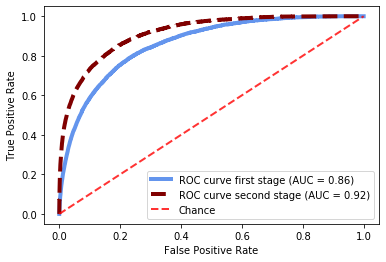

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


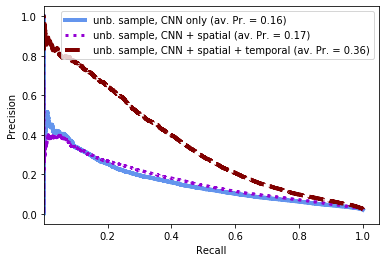

precision in the balanced sample with rf is 0.9151133520595794
precision in the unbalanced sample with rf is 0.35703492446673496
precision in the balanced sample with ens is 0.9022432305350319
precision in the unbalanced sample with ens is 0.3097618688772279
AUC with RF is 0.9150348397948997
AUC with ENS is 0.9031832900170923
diplaying data for city: daraa
****************************************************
available image dates
2016-12-05    15574
2014-04-04    15574
2016-04-19    15574
2016-02-25    15574
2014-05-01    15574
2012-09-06    15574
2017-10-03    15574
2017-02-07    15574
2016-07-18    15574
2013-11-10    15574
2014-06-03    15574
2011-10-17    15574
2017-06-02    15574
Name: date, dtype: int64
****************************************************
calculate performance in test sample
Looking at  daraa
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34156 entries, 0 to 34155
Data columns (total 15 columns):
index            34156 non-null int64
prediction       34156 non

D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of

apply temporal
apply spatial
apply one lag model


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Producing graphs for daraa


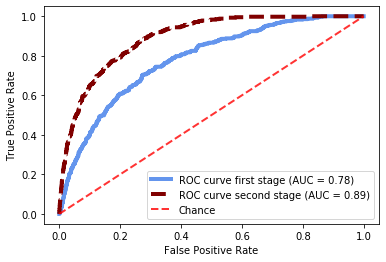

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


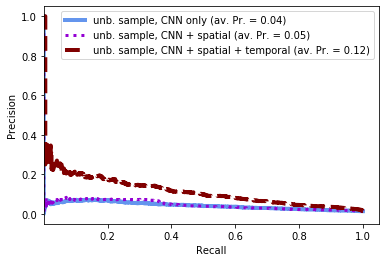

precision in the balanced sample with rf is 0.8742869793771372
precision in the unbalanced sample with rf is 0.11671990279954289
precision in the balanced sample with ens is 0.8585644378982079
precision in the unbalanced sample with ens is 0.09891777428128921
AUC with RF is 0.8900533881021934
AUC with ENS is 0.8761049938370611
diplaying data for city: deir-ez-zor
****************************************************
available image dates
2014-11-25    14086
2016-05-25    14086
2014-10-15    14086
2016-04-17    14086
2013-10-24    14086
2016-07-06    14086
2014-09-16    14086
Name: date, dtype: int64
****************************************************
calculate performance in test sample


D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of

Looking at  deir-ez-zor
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25175 entries, 0 to 25174
Data columns (total 15 columns):
index            25175 non-null int64
prediction       25175 non-null float64
destroyed        25175 non-null float64
prediction_l1    25175 non-null float64
prediction_l2    25175 non-null float64
prediction_f1    25175 non-null float64
prediction_f2    25175 non-null float64
std              25175 non-null float64
std2             25175 non-null float64
count            25175 non-null int64
count2           25175 non-null int64
sum_bin          25175 non-null int64
sum_bin2         25175 non-null int64
pred_c1          25175 non-null float64
pred_c2          25175 non-null float64
dtypes: float64(10), int64(5)
memory usage: 2.9 MB
this means the zeros have a weight that is 34.6586402266289 times higher
apply forest
apply temporal
apply spatial
apply one lag model


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Producing graphs for deir-ez-zor


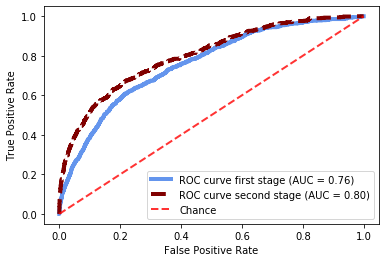

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


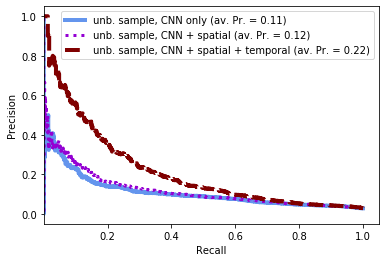

precision in the balanced sample with rf is 0.8133931683204527
precision in the unbalanced sample with rf is 0.21693285107707724
precision in the balanced sample with ens is 0.7987167215483553
precision in the unbalanced sample with ens is 0.20170447980729145
AUC with RF is 0.8002381344632515
AUC with ENS is 0.7866173849851295
diplaying data for city: hama
****************************************************
available image dates
2016-07-29    31673
2013-10-31    31673
2012-07-17    31673
2014-05-25    31673
2016-12-11    31673
2014-04-03    31673
2014-06-13    31673
2016-06-30    31673
2016-05-18    31673
Name: date, dtype: int64
****************************************************
calculate performance in test sample
Looking at 

D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of

 hama
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64511 entries, 0 to 64510
Data columns (total 15 columns):
index            64511 non-null int64
prediction       64511 non-null float64
destroyed        64511 non-null float64
prediction_l1    64511 non-null float64
prediction_l2    64511 non-null float64
prediction_f1    64511 non-null float64
prediction_f2    64511 non-null float64
std              64511 non-null float64
std2             64511 non-null float64
count            64511 non-null int64
count2           64511 non-null int64
sum_bin          64511 non-null int64
sum_bin2         64511 non-null int64
pred_c1          64511 non-null float64
pred_c2          64511 non-null float64
dtypes: float64(10), int64(5)
memory usage: 7.4 MB
this means the zeros have a weight that is 24.160296411856475 times higher
apply forest
apply temporal
apply spatial
apply one lag model


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Producing graphs for hama


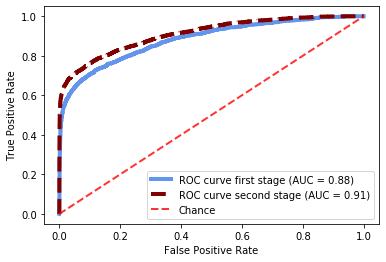

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


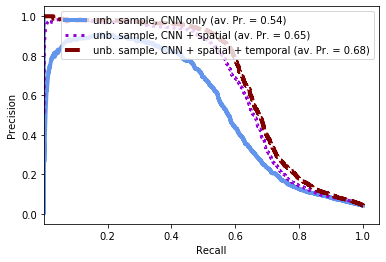

precision in the balanced sample with rf is 0.9275586027780633
precision in the unbalanced sample with rf is 0.6804844855759784
precision in the balanced sample with ens is 0.9255336651651919
precision in the unbalanced sample with ens is 0.677995607676407
AUC with RF is 0.9099538929496548
AUC with ENS is 0.9068311742106954
diplaying data for city: homs
****************************************************
available image dates
2013-10-31    40007
2016-07-05    40007
2014-06-09    40007
2014-04-03    40007
2016-05-30    40007
Name: date, dtype: int64
****************************************************
calculate performance in test sample
Looking at  homs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25093 entries, 0 to 25092
Data columns (total 15 columns):
index            25093 non-null int64
prediction       25093 non-null float64
destroyed        25093 non-null float64
prediction_l1    25093 non-null float64
prediction_l2    25093 non-null float64
prediction_f1    25093 non-nul

D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of

apply temporal
apply spatial
apply one lag model


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Producing graphs for homs


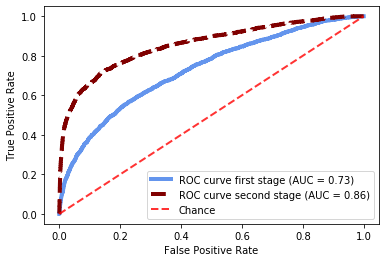

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


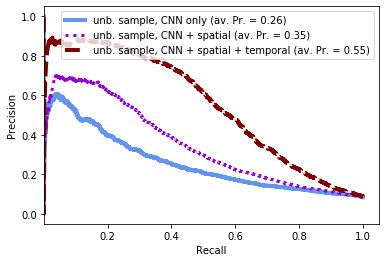

precision in the balanced sample with rf is 0.8765527625290435
precision in the unbalanced sample with rf is 0.5520063910518642
precision in the balanced sample with ens is 0.8701297154639402
precision in the unbalanced sample with ens is 0.5181032393522774
AUC with RF is 0.8565488556969288
AUC with ENS is 0.8540716905361936
diplaying data for city: raqqa
****************************************************
available image dates
2014-10-06    22523
2014-03-21    22523
2015-02-02    22523
2016-02-20    22523
2016-09-23    22523
2013-02-13    22523
2016-07-01    22523
2014-05-18    22523
Name: date, dtype: int64
****************************************************
calculate performance in test sample
Looking at  raqqa
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33336 entries, 0 to 33335
Data columns (total 15 columns):
index            33336 non-null int64
prediction       33336 non-null float64
destroyed        33336 non-null float64
prediction_l1    33336 non-null float64
predict

D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
D:\apps\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of

apply temporal
apply spatial
apply one lag model


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Producing graphs for raqqa


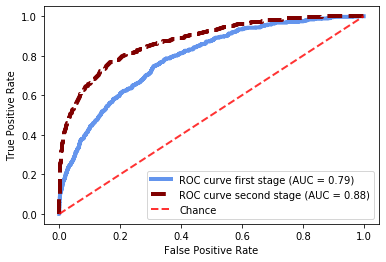

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


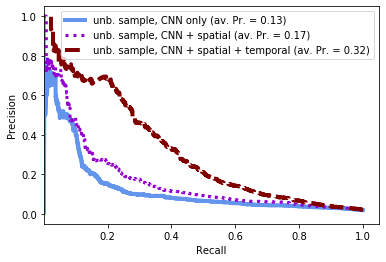

precision in the balanced sample with rf is 0.8864249369044632
precision in the unbalanced sample with rf is 0.3205751810336952
precision in the balanced sample with ens is 0.8759398776492464
precision in the unbalanced sample with ens is 0.2844757237032218
AUC with RF is 0.8755242923069196
AUC with ENS is 0.8653405177400573
          city      date  numberofdates        obs     labels  labels1  \
0          all  alldates           61.0  3072752.0  2206591.0  51070.0   
0       aleppo  alldates           22.0  2106412.0  1597229.0  29691.0   
0        daraa  alldates           13.0   202462.0   123981.0   1250.0   
0  deir-ez-zor  alldates            7.0    98602.0    82299.0   2424.0   
0         hama  alldates            9.0   285057.0   215998.0   8367.0   
0         homs  alldates            5.0   200035.0    77008.0   6933.0   
0        raqqa  alldates            8.0   180184.0   110076.0   2405.0   

      AUC_1  avprecision1to1_1  avprecision_1    AUC_sp  ...  avprecision_sp  \


0

In [13]:
#apply the model to all patches in the test sample by city waves and calculate performance
df_by_date = corpus.groupby(['city'])
date="alldates"
df_by_date.describe()
for date_loop, wave in df_by_date:
    print("diplaying data for city:", date_loop)
    print("****************************************************")
    print("available image dates")
    print(wave.date.value_counts())
    print("****************************************************")
    print("calculate performance in test sample")
    performance=list(applymodel(functions[0], functions[1], functions[2], functions[3], date_loop, wave[testset], 1))
    #replace test sample stats with overall stats for observations and labels
    performance[0]=wave.prediction.count()
    performance[1]=wave.destroyed.value_counts()[0]
    performance[2]=wave.destroyed.value_counts()[1]
    #write results in separate df
    resultswriter(date_loop, date, len(wave.date.value_counts()), performance)

print(results)     
results.to_csv(spitout + "performance_stats.csv", sep='\t', encoding='utf-8')

#output tables with STATA
#this makes summary stats table and table 1
dofile = path+"make_tables.do"
cmd = [statapath, "-e", "do", dofile, path, spitout]
subprocess.call(cmd)


In [14]:
#as a final step train second stage on entire labelled dataset
functions=estimatemodel(corpus, target)

citylist=["deir-ez-zor","raqqa","hama","daraa","homs","aleppo"]

for cityname in citylist:
    print("applying to " + cityname)
    date="alldates"
    applymodelsaveout(functions[0], functions[1], functions[2], functions[3], cityname, citydata[cityname])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2257661 entries, 0 to 2257660
Data columns (total 15 columns):
index            int64
prediction       float64
destroyed        float64
prediction_l1    float64
prediction_l2    float64
prediction_f1    float64
prediction_f2    float64
std              float64
std2             float64
count            int64
count2           int64
sum_bin          int64
sum_bin2         int64
pred_c1          float64
pred_c2          float64
dtypes: float64(10), int64(5)
memory usage: 258.4 MB
estimating forest with lags
estimating forest with only spatial lags
estimating forest with only temporal lags
estimating forest with one temporal lag
applying to deir-ez-zor
Looking at  deir-ez-zor
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84723 entries, 0 to 84722
Data columns (total 15 columns):
index            84723 non-null int64
prediction       84723 non-null float64
destroyed        84723 non-null float64
prediction_l1    84723 non-null float64
pre

applying to daraa
Looking at  daraa
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125231 entries, 0 to 125230
Data columns (total 15 columns):
index            125231 non-null int64
prediction       125231 non-null float64
destroyed        125231 non-null float64
prediction_l1    125231 non-null float64
prediction_l2    125231 non-null float64
prediction_f1    125231 non-null float64
prediction_f2    125231 non-null float64
std              125231 non-null float64
std2             125231 non-null float64
count            125231 non-null float64
count2           125231 non-null float64
sum_bin          125231 non-null float64
sum_bin2         125231 non-null float64
pred_c1          125231 non-null float64
pred_c2          125231 non-null float64
dtypes: float64(14), int64(1)
memory usage: 14.3 MB
this means the zeros have a weight that is 99.18479999999998 times higher
apply forest
apply spatial forest
apply temporal forest
apply temporal one lag
<class 'pandas.core.frame.DataFrame